In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb

In [ ]:
data_df = pd.read_csv('Merged01.csv')
print(data_df.shape)
data_df.head()

(712311, 40)


,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,Label
0,19.92,6,63.36,25893.962218,0.0,0.0,0.0,0.99,0.99,0.0,...,6421,60,481,64.21,42.100000,64.21,0.000039,100,1772.410000,DDOS-PSHACK_FLOOD
1,0.00,47,64.00,3703.841331,0.0,0.0,0.0,0.00,0.00,0.0,...,57320,98,578,573.20,48.000000,573.20,0.000271,100,2304.000000,MIRAI-GREIP_FLOOD
2,7.92,17,65.91,19673.095685,0.0,0.0,0.0,0.00,0.00,0.0,...,6010,60,70,60.10,1.000000,60.10,0.000057,100,1.000000,DOS-UDP_FLOOD
3,20.40,6,110.50,261.664826,0.1,0.0,0.3,0.20,0.40,0.0,...,2223,54,1500,222.30,451.596686,222.30,0.004766,10,203939.566667,DNS_SPOOFING
4,0.32,1,63.96,28944.199848,0.0,0.0,0.0,0.00,0.01,0.0,...,6006,60,66,60.06,0.600000,60.06,0.000035,100,0.360000,DDOS-ICMP_FLOOD


In [ ]:
# Verificar colunas com valores infinitos
inf_mask = data_df.applymap(lambda x: np.isinf(x) if isinstance(x, (int, float, np.number)) else False)

# Filtrar colunas com pelo menos um valor infinito
colunas_com_inf = inf_mask.any(axis=0)

# Exibir nomes das colunas com infinitos
print("Colunas com valores infinitos:")
print(colunas_com_inf[colunas_com_inf].index.tolist())

/tmp/ipython-input-3646384210.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  inf_mask = data_df.applymap(lambda x: np.isinf(x) if isinstance(x, (int, float, np.number)) else False)


Colunas com valores infinitos:
['Rate']


In [ ]:
# Criar máscara para linhas sem inf na coluna 'Rate'
mask = ~np.isinf(data_df['Rate'])

# Filtrar o DataFrame para remover linhas com inf
data_df = data_df[mask].reset_index(drop=True)

print(data_df.shape)

# Verificar colunas com valores infinitos
inf_mask = data_df.applymap(lambda x: np.isinf(x) if isinstance(x, (int, float, np.number)) else False)

# Filtrar colunas com pelo menos um valor infinito
colunas_com_inf = inf_mask.any(axis=0)

# Exibir nomes das colunas com infinitos
print("Colunas com valores infinitos:")
print(colunas_com_inf[colunas_com_inf].index.tolist())

(712297, 40)


/tmp/ipython-input-1782869003.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  inf_mask = data_df.applymap(lambda x: np.isinf(x) if isinstance(x, (int, float, np.number)) else False)


Colunas com valores infinitos:
[]


In [ ]:
attack_class_mapping = {
    # DDoS
    'DDOS-PSHACK_FLOOD': 'DDoS',
    'DDOS-ICMP_FLOOD': 'DDoS',
    'DDOS-TCP_FLOOD': 'DDoS',
    'DDOS-SYN_FLOOD': 'DDoS',
    'DDOS-UDP_FLOOD': 'DDoS',
    'DDOS-SYNONYMOUSIP_FLOOD': 'DDoS',
    'DDOS-RSTFINFLOOD': 'DDoS',
    'DDOS-SLOWLORIS': 'DDoS',
    'DDOS-ICMP_FRAGMENTATION': 'DDoS',
    'DDOS-ACK_FRAGMENTATION': 'DDoS',
    'DDOS-UDP_FRAGMENTATION': 'DDoS',
    'DDOS-HTTP_FLOOD': 'DDoS',

    # DoS
    'DOS-UDP_FLOOD': 'DoS',
    'DOS-TCP_FLOOD': 'DoS',
    'DOS-SYN_FLOOD': 'DoS',
    'DOS-HTTP_FLOOD': 'DoS',

    # Recon
    'RECON-HOSTDISCOVERY': 'Recon',
    'VULNERABILITYSCAN': 'Recon',
    'RECON-PORTSCAN': 'Recon',
    'RECON-OSSCAN': 'Recon',
    'RECON-PINGSWEEP': 'Recon',

    # Web-based
    'XSS': 'Web-based',
    'SQLINJECTION': 'Web-based',
    'COMMANDINJECTION': 'Web-based',
    'BACKDOOR_MALWARE': 'Web-based',
    'UPLOADING_ATTACK': 'Web-based',
    'BROWSERHIJACKING': 'Web-based',

    # Brute Force
    'DICTIONARYBRUTEFORCE': 'Brute Force',

    # Spoofing
    'DNS_SPOOFING': 'Spoofing',
    'MITM-ARPSPOOFING': 'Spoofing',

    # Mirai
    'MIRAI-GREIP_FLOOD': 'Mirai',
    'MIRAI-GREETH_FLOOD': 'Mirai',
    'MIRAI-UDPPLAIN': 'Mirai',

    # Benigno
    'BENIGN': 'BENIGN'
}

attack_class_to_num = {
    'BENIGN': 0,
    'DDoS': 1,
    'DoS': 2,
    'Recon': 3,
    'Web-based': 4,
    'Brute Force': 5,
    'Spoofing': 6,
    'Mirai': 7
}

In [ ]:
# Cria nova coluna com a classe textual
data_df['Attack_Type'] = data_df['Label'].map(attack_class_mapping)
data_df['Attack_Class'] = data_df['Attack_Type'].map(attack_class_to_num)
print("Distribuição de classes (absoluta)")
print(data_df['Attack_Class'].value_counts())
print("Distribuição de classes (percentual)")
print(data_df['Attack_Class'].value_counts(normalize=True) * 100)
data_df.head()

Distribuição de classes (absoluta)
Attack_Class
1    515113
2    122494
7     39661
0     16574
3     10562
6      7328
4       361
5       204
Name: count, dtype: int64
Distribuição de classes (percentual)
Attack_Class
1    72.317165
2    17.197040
7     5.568043
0     2.326838
3     1.482808
6     1.028784
4     0.050681
5     0.028640
Name: proportion, dtype: float64


,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Max,AVG,Std,Tot size,IAT,Number,Variance,Label,Attack_Type,Attack_Class
0,19.92,6,63.36,25893.962218,0.0,0.0,0.0,0.99,0.99,0.0,...,481,64.21,42.100000,64.21,0.000039,100,1772.410000,DDOS-PSHACK_FLOOD,DDoS,1
1,0.00,47,64.00,3703.841331,0.0,0.0,0.0,0.00,0.00,0.0,...,578,573.20,48.000000,573.20,0.000271,100,2304.000000,MIRAI-GREIP_FLOOD,Mirai,7
2,7.92,17,65.91,19673.095685,0.0,0.0,0.0,0.00,0.00,0.0,...,70,60.10,1.000000,60.10,0.000057,100,1.000000,DOS-UDP_FLOOD,DoS,2
3,20.40,6,110.50,261.664826,0.1,0.0,0.3,0.20,0.40,0.0,...,1500,222.30,451.596686,222.30,0.004766,10,203939.566667,DNS_SPOOFING,Spoofing,6
4,0.32,1,63.96,28944.199848,0.0,0.0,0.0,0.00,0.01,0.0,...,66,60.06,0.600000,60.06,0.000035,100,0.360000,DDOS-ICMP_FLOOD,DDoS,1


In [ ]:
# Separar X e y
X = data_df.drop(columns=['Label', 'Attack_Type', 'Attack_Class'])
y = data_df['Attack_Class']                 # coluna alvo

# 1º Split: Treino + Temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 2º Split: Validação e Teste
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Converter para DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_test, label=y_test)

# Resultado
print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

Train: (498607, 39)
Val: (106845, 39)
Test: (106845, 39)


In [ ]:
# Parâmetros
params = {
    'objective': 'multi:softprob',
    'num_class': 8,
    'eval_metric': 'mlogloss',
    'verbosity': 1
}

evals_result = {}
evals = [(dtrain, 'train'), (dval, 'val')]
num_boost_round=100

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=evals,
    evals_result=evals_result,
    early_stopping_rounds=10,
    verbose_eval=True
)

[0]	train-mlogloss:1.28793	val-mlogloss:1.28793
[1]	train-mlogloss:0.99265	val-mlogloss:0.99347
[2]	train-mlogloss:0.81000	val-mlogloss:0.81100
[3]	train-mlogloss:0.68557	val-mlogloss:0.68667
[4]	train-mlogloss:0.59718	val-mlogloss:0.59853
[5]	train-mlogloss:0.53116	val-mlogloss:0.53262
[6]	train-mlogloss:0.48271	val-mlogloss:0.48437
[7]	train-mlogloss:0.44545	val-mlogloss:0.44729
[8]	train-mlogloss:0.41738	val-mlogloss:0.41934
[9]	train-mlogloss:0.39535	val-mlogloss:0.39737
[10]	train-mlogloss:0.37830	val-mlogloss:0.38044
[11]	train-mlogloss:0.36453	val-mlogloss:0.36684
[12]	train-mlogloss:0.35270	val-mlogloss:0.35514
[13]	train-mlogloss:0.34356	val-mlogloss:0.34613
[14]	train-mlogloss:0.33609	val-mlogloss:0.33885
[15]	train-mlogloss:0.32998	val-mlogloss:0.33283
[16]	train-mlogloss:0.32509	val-mlogloss:0.32802
[17]	train-mlogloss:0.32081	val-mlogloss:0.32387
[18]	train-mlogloss:0.31718	val-mlogloss:0.32034
[19]	train-mlogloss:0.31411	val-mlogloss:0.31739
[20]	train-mlogloss:0.31144	va

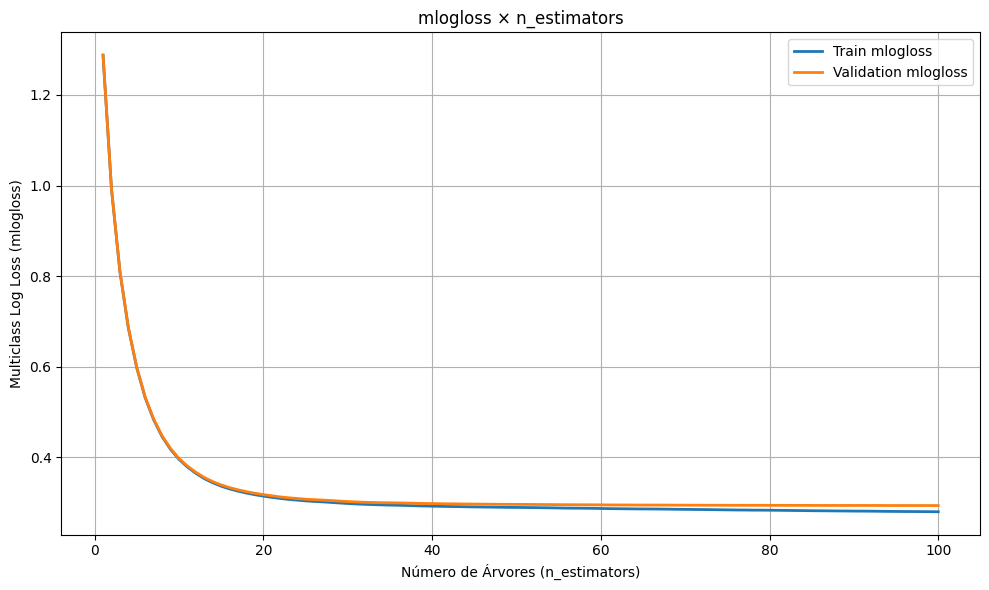

In [ ]:
# Plotar mlogloss vs n_estimators
train_mlogloss = evals_result['train']['mlogloss']
eval_mlogloss = evals_result['val']['mlogloss']
rounds = list(range(1, num_boost_round + 1))

plt.figure(figsize=(10, 6))
plt.plot(rounds, train_mlogloss, label='Train mlogloss', linewidth=2)
plt.plot(rounds, eval_mlogloss, label='Validation mlogloss', linewidth=2)
plt.xlabel('Número de Árvores (n_estimators)')
plt.ylabel('Multiclass Log Loss (mlogloss)')
plt.title('mlogloss × n_estimators')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

📊 Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.88      0.84      2486
         1.0       0.86      0.97      0.91     77267
         2.0       0.72      0.36      0.48     18374
         3.0       0.76      0.74      0.75      1584
         4.0       0.40      0.07      0.12        54
         5.0       0.71      0.16      0.26        31
         6.0       0.94      0.83      0.88      1100
         7.0       1.00      1.00      1.00      5949

    accuracy                           0.86    106845
   macro avg       0.78      0.63      0.66    106845
weighted avg       0.84      0.86      0.84    106845

✅ Accuracy: 0.8564556132715616


<Figure size 800x600 with 0 Axes>

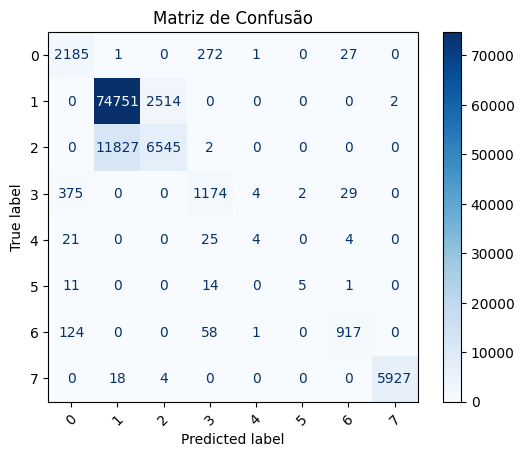

In [ ]:
# Previsões em forma de probabilidade
y_pred_prob = model.predict(dtest)

# Converter para rótulos (classe com maior probabilidade)
y_pred = np.argmax(y_pred_prob, axis=1)

# Valores reais
y_true = dtest.get_label()

print("📊 Classification Report:")
print(classification_report(y_true, y_pred))

print("✅ Accuracy:", accuracy_score(y_true, y_pred))

# Gerar a matriz de confusão
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plotar a imagem
plt.figure(figsize=(8,6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Matriz de Confusão')
plt.show()